# Tarea 6:  Superresoluci´on usando un modelo Unet

## Aprendizaje de Autom´atico I

### Esteban Reyes Saldaña

# Resumen

En esta tarea se utilizó la implementación de la UNet en keras del Dr. Mariano Rivera
http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/unet/unet_segmentacion.html
donde segmenta imágenes del dataset $ MNIST $ para hacer Super-resolución de imágenes $png$ a tres canales (RGB). Luego de haber entrenado a la UNet, la utilizaremos para darle imágenes de baja resolución y obtener imágenes de doble tamaño.

Finalmente se compara el error de reconstrucción con interpolación bicúbica.

# Introducción

Este esquema nos recuerda un poco a las redes residuales, que a groso modo se basan en bloqes que implementan $ x = x + F(x)x=x+F(x) $. La primara cuestión que surge con el bloque ResNet es si la suma es la mejor forma de combinar el vector de entrada y el procesado (residual). la respuesta es que no lo sabemos, por lo que lo mejro seria dejar a que este forma de combinar ambos tensores sea aprendida por la red.


El nuevo esquema mostrado es una generalización al bloque ResNet. A este componete elemental de la Unet llamaremos Bloque-U e implementa la operación

$$ \hat{x} = G([x | F(x)]) $$

donde $ [ | ] $ representa el operador de concatenación, $ G $ es el mecanismo aprendido para combinar $ x $ y $ F(x)$. Note que si $F = \varnothing $  el bloque se comporta como un simple convolucional $ \hat{x} =  G(x) $.

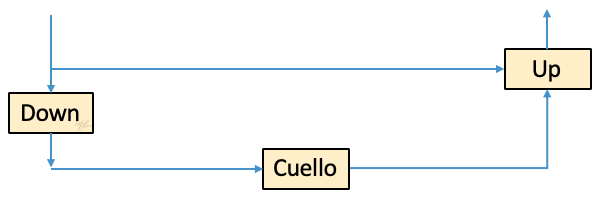

En este bloque pretenderemos que $ F(x) $ implemente un procesamiento sobre $ x $ que implique la estimación de características de mayor complejidad (mas profundas) que las realizadas por $ G $, por ello el **Bloque Down** será convolucional: increementará los canales y decrementará las dimensiones espaciales de $ x $.

El **Bloque Up**, además de implementar la transformación $ G $, ajustará las dimensiones de los tensores de entrada para que sean concatenables.

El **Bloque Cuello de Botella** implementará un procesamiento extra que implicará estimar características mas profundas (mayor complejidad) en $ x $. Y es aquí donde ocurre la mayor diferencia con la ResNet, podemos implementar el cuello de botella como otro Bloque-U como se ilustra en la siguiente figura.

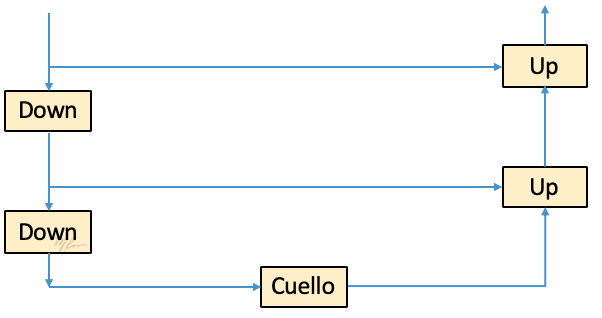

Que resulta en el el modelo matemático definido por

$$ \hat{x_0} = G_1 ([x_0 | G_2(x_1) | F(x) ] ) $$

Este construcción recursiva la podemos continuar en tanto la dimensiones espaciales de $x$ lo permitan. Luego en una siguiente recursión tendremos un esquema como el que a continuación se ilustra.

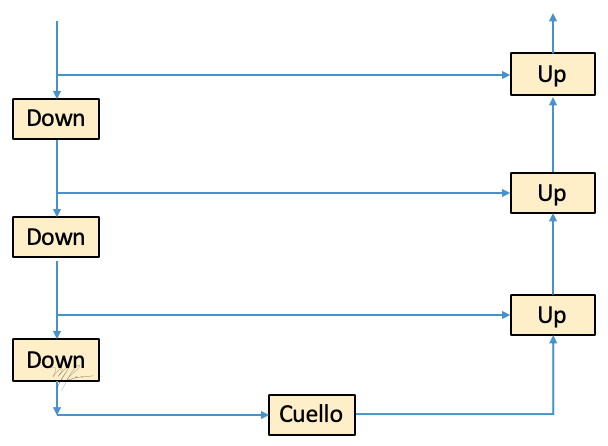

Este es el principio de la Unet propueta por Ronneberger et al. (2015), y se relaciona intimamente con los autoencodificadores en el sentido de que tenemos un tensor de entrada y uno de salida. Su arquitectura es muy similar, solo que ahora, tenemos ligas puente entre distintos niveles del autocodificador por lo que pretendemos tener una versión comprimida de los dato en alguna etapa intermedia; la red no es entendible como un sitema compuestompor un codificador y un decodificador, sino es un sistema completo.

# UNet para Super-resolución

La tarea a la que nos enfocaremos es la super-resolución de imágenes (parches). En el esquema anterior, las ligas indican el flujo de datos y las dimensiones de los tensores se ulustran en el formato (num_canales, num_genglones, num_columnas). Notemos que conforme vamos a niveles más profundos los tensores incrementan en número de canales y decrementan es dimensiones espaciales.

Particularmente, tomaremos un conjunto de imágenes de las cuales obtendremos $ 10,000 $ parches de tamaño $ (32 \times 32) $ a los que llamaremos $ y_i $, con $i \in \{ 0, 1, \dots, 10,000 \} $. A dichos parches les reduciremos la dimensión a $ (16 \times 16) $ y los llamaremos $ x_i $. Entonces la entrada de nuestra red serán los parches de baja dimensión $ X = \lbrack x_0, x_1, \dots, x_{9999} \rbrack$ y la salida serán los parches de alta resolución $ Y = \lbrack y_0, y_1, \dots, y_{9999} \rbrack $.

# Implementación en Keras de la UNet

# Librerías

In [2]:
# Librerías
import cv2
import time
import numpy as np
from os import listdir

from tensorflow.image import resize as tf_resize_image
from tensorflow.compat.v1.keras.backend import get_session
from tensorflow.compat.v1.keras import backend as tf
from tensorflow.keras import models

import keras
from keras.layers import Input, Dense, Flatten, Activation, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras.layers import BatchNormalization, ReLU, Lambda, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

# Lectura de Datos

Utilizaremos la base de datos **Flickr-Faces-HQ Dataset (FFHQ)**. Que son imágenes de alta resolución $(1024 \times 1024)$ en formato png. Los detalles están en 
https://github.com/NVlabs/ffhq-dataset

In [3]:
dir = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Aprendizaje_Profundo/Tarea6/images1024x1024/00000/'

Utilizaremos $ 50 $ imágenes para obtener $ 10,000 $ parches y $10$ imágenes para probar superresolución.

In [4]:
# Extraigo 60 imágenes, 50 entrenamiento, 10 pruebas
dataset_names = np.random.choice(listdir(dir), size = 60, replace = False)

print('Número de imágenes elegidas: ', len(dataset_names))
print(dataset_names)

Número de imágenes elegidas:  60
['00008.png' '00206.png' '00387.png' '00695.png' '00878.png' '00341.png'
 '00188.png' '00122.png' '00817.png' '00642.png' '00837.png' '00194.png'
 '00505.png' '00203.png' '00516.png' '00769.png' '00476.png' '00034.png'
 '00723.png' '00355.png' '00365.png' '00198.png' '00347.png' '00533.png'
 '00663.png' '00048.png' '00330.png' '00526.png' '00710.png' '00820.png'
 '00258.png' '00519.png' '00299.png' '00012.png' '00756.png' '00989.png'
 '00467.png' '00221.png' '00825.png' '00845.png' '00057.png' '00288.png'
 '00993.png' '00116.png' '00515.png' '00183.png' '00568.png' '00883.png'
 '00910.png' '00766.png' '00622.png' '00783.png' '00826.png' '00358.png'
 '00798.png' '00507.png' '00494.png' '00303.png' '00624.png' '00559.png']


In [23]:
# Cargamos imágenes a tres canales
images = [cv2.imread(dir + f_name) for f_name in dataset_names]

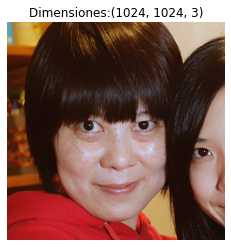

In [24]:
plt.axis("off")
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title('Dimensiones:' + str(images[0].shape))
plt.show()

Primeras diez imágenes de entrenamiento


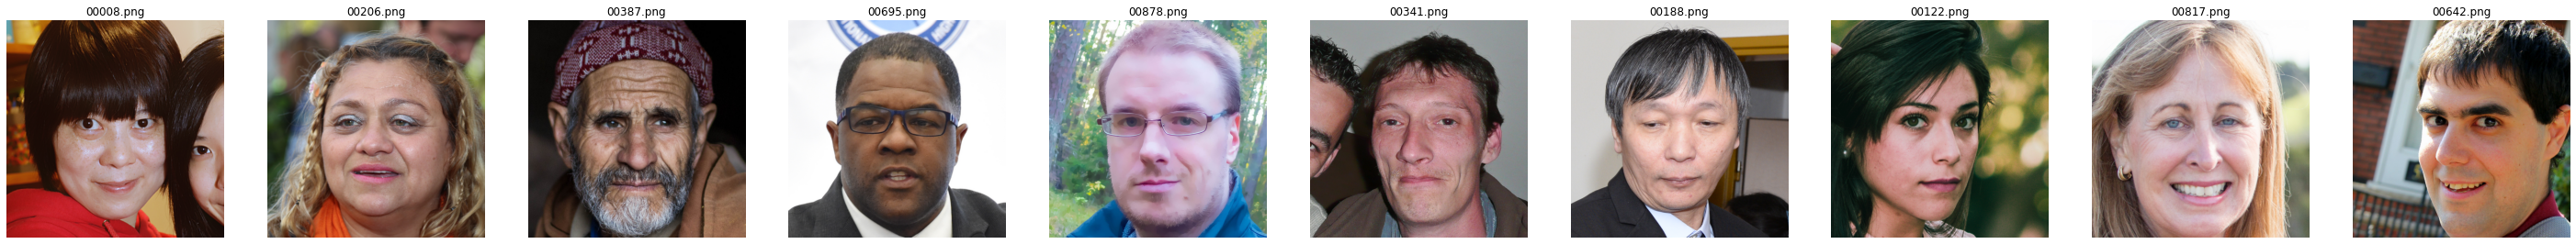

In [26]:
print('Primeras diez imágenes de entrenamiento')
plt.figure(figsize = (50,50))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(dataset_names[i])
    plt.axis('off')

Imágenes de prueba


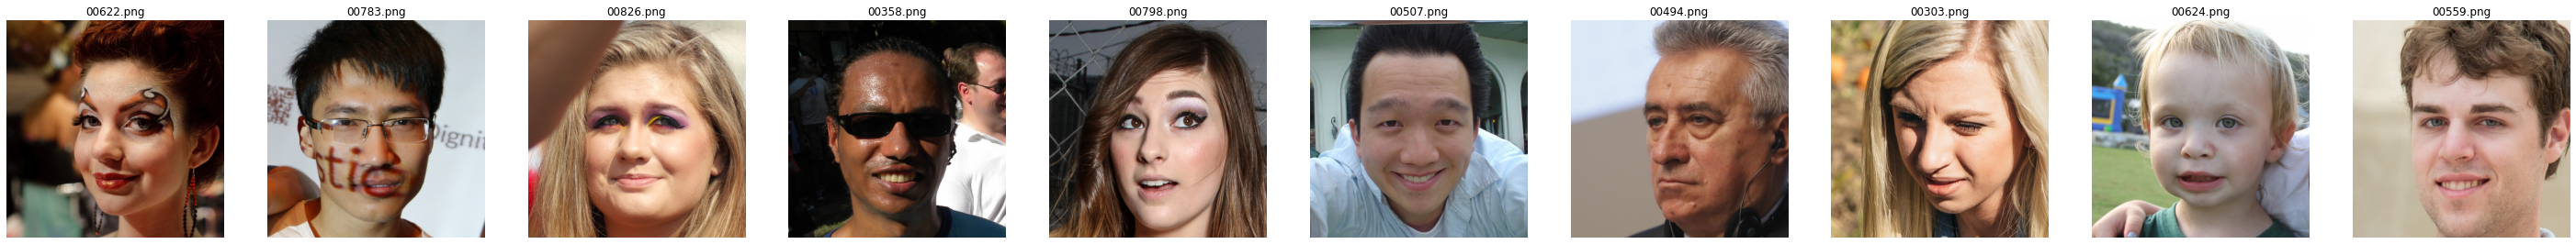

In [28]:
print('Imágenes de prueba')
plt.figure(figsize = (50,50))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(cv2.cvtColor(images[i +50], cv2.COLOR_BGR2RGB))
    plt.title(dataset_names[i + 50])
    plt.axis('off')

# Construcción del Dataset

In [37]:
def build_patches(images, samples = 100, size = (32, 32,3)):
  '''
  Creo parches del conjunto de imágenes de manera aleatoria
  Parámetros
  -----------
    images  : Conjunto de imágenes
    samples : Total de parches a obtener
    size    : Dimensión de cada parche
  Regresa 
  -----------
    patches: array de parches
  '''
  patches = []
  # Elijo de manera aleatoria imágenes 
  n_images = len(images)
  for k in np.random.randint(0, n_images, size = samples):
    h, w, _ = images[k].shape
    # Elijo pixel acotando rango de elección
    x = np.random.randint(0, h - size[0])
    y = np.random.randint(0, w - size[1])
    patches.append(images[k][y : y + size[0], x : x + size[1]])

  return patches

In [38]:
def build_dataset(images, samples = 100, patch_size = (32,32,3), subsample_size = (16,16,3)):
  '''
  Construye conjunto de entrenamiento generando patches
  Parámetros
  -----------
    images         : Conjunto de imágenes
    samples        : Total de parches a obtener
    patch_size     : Dimensión de cada parche
    subsample_size : Dimensión del parche a submuestrear
  Regresa
  -----------
    x              : parches con dimensión reducida
    y              : parches de baja dimensión
  '''
  # Obtengo parches
  patches = build_patches(images, samples = samples, size = patch_size)
  # Parches con reducción de dimensión
  x = [cv2.resize(img, subsample_size[:2], interpolation = cv2.INTER_LINEAR) for img in patches]
  return x, patches

In [39]:
num_patches    = 10000
patch_size     = (32,32,3)
subsample_size = (16,16,3)

In [40]:
x, y = build_dataset(images[:50], samples   = num_patches, 
                             patch_size     = patch_size, 
                             subsample_size = subsample_size)

In [41]:
# Normalizamos dataset
X_train = np.copy(x).astype(np.float32) / 255.
Y_train = np.copy(y).astype(np.float32) / 255.

In [42]:
# Conjunto de Validación
val_size = (512, 512,3)
X_test   = [cv2.resize(img, val_size[:2], interpolation = cv2.INTER_LINEAR) for img in images[50:]]
X_test   = np.copy(X_test).astype(np.float32) / 255.
Y_test   = np.copy(images[50:]).astype(np.float32) / 255.

In [45]:
print('Dimensión de parches                        : ', Y_train.shape)
print('Dimensión de parches reducidos              : ', X_train.shape)
print('Dimensiones de entradas (X) para evaluación : ', X_test.shape)
print('Dimensiones de salida (Y) para evaluación    : ', Y_test.shape)

Dimensión de parches                        :  (10000, 32, 32, 3)
Dimensión de parches reducidos              :  (10000, 16, 16, 3)
Dimensiones de entradas (X) para evaluación :  (10, 512, 512, 3)
Dimensiones de salida (Y) para evaluación    :  (10, 1024, 1024, 3)


## Muestro algunos parches

Primeros diez parches


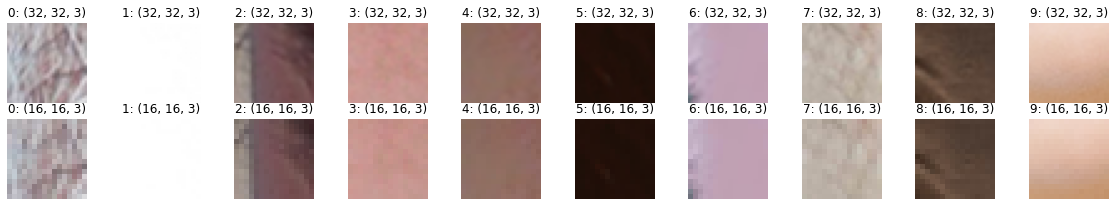

In [52]:
print('Primeros diez parches')
plt.figure(figsize = (20,5))

for i in range(10):
    plt.subplot(3,10,i+1)
    plt.title(str(i) + ': ' + str(patch_size))
    plt.imshow(cv2.cvtColor(np.copy(Y_train[i]).astype('float32'), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(3,10,i + 1 + 10)
    plt.title(str(i) + ': ' + str(subsample_size))
    plt.imshow(cv2.cvtColor(np.copy(X_train[i]).astype('float32'), cv2.COLOR_BGR2RGB))
    plt.axis('off')


# UNet Usando Keras

La lista `filters_per_block` define el número de canales en cada etapa de la Unet, la profundidad de la Unet se adapta de acuerdo a la longitud de dicha lista.

In [53]:
_, num_rows, num_cols, num_channels = X_train.shape
img_dim                             = (num_rows, num_cols, num_channels,)
filters_per_block                   = np.array([num_channels, 32, 64, 128])
num_blocks                          = len(filters_per_block)   
kernel_size                         = (3,3)
drop                                = 0.25*np.ones(num_blocks)
drop

array([0.25, 0.25, 0.25, 0.25])

**Encoder**
Los bloques convolucionales **Down*** tienen la estructura:


1.   Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial.
2.   Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial.
3.   Dropoout del $25\%$ (parametro definible).
4.   MaxPolling 2x2 que reduce la dimensión espacial.

No se usa **Bloque Cuello de Botella**.

In [59]:
nm    = 'encoder'
Xdicc = {}

Xin  = Input(shape = X_train[0].shape)
X    = Lambda(lambda image: tf_resize_image(image, (32, 32)))(Xin)
# resize image layer
Xdicc[0]   = X
numFilters = filters_per_block[0]

print(0, numFilters, X.shape)

for i in range(1,num_blocks):
    numFilters = filters_per_block[i]
    X = Conv2D(numFilters, kernel_size = kernel_size, padding = 'same', activation = 'relu', name = 'encoder-conv1'+str(i))(X) 
    X = Conv2D(numFilters, kernel_size  =kernel_size, padding = 'same', activation = 'relu', name = 'encoder-conv2'+str(i))(X)
    X = Dropout(rate = drop[i], name = 'encoder-drop'+str(i))(X)
    X = MaxPooling2D(pool_size = (2,2), padding = 'valid', name = 'encoder-maxpool'+str(i))(X)
    Xdicc[i] = X
    print(i, numFilters, Xdicc[i].shape)  

0 3 (None, 32, 32, 3)
1 32 (None, 16, 16, 32)
2 64 (None, 8, 8, 64)
3 128 (None, 4, 4, 128)


**Decoder**


Los bloques convolucionales Up tienen la estructura:

Dados la salida del bloque anterior **Y** y la del **Bloque Down** espejo $$Xdicc[i-1]$$

1. Supermuestrear: Y <- UpSample(Y)

2. Concatenar: $ Y | Xdicc[i-1] $

3. Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial

4. Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial

5. Dropoout del 25% (parametro definible)

In [60]:
# Decoder
Y = X
for i in range(num_blocks - 1, 0, -1):
    if i > 1:
        numFilters = filters_per_block[i-1] 
    else:
        numFilters = 32
    #print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = UpSampling2D(size = 2, name = 'decoder-up' + str(i))(Y)  
    print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2'+str(i))(Y)
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3'+str(i))(Y)
    Y = Dropout(rate=drop[i], name='decoder-drop'+str(i))(Y)

3 64 (None, 8, 8, 128) (None, 8, 8, 64)
2 32 (None, 16, 16, 64) (None, 16, 16, 32)
1 32 (None, 32, 32, 32) (None, 32, 32, 3)


**Tail**


El Bloque **Tail**, contienne dos capas convolucionales: la primera reduce el número de canales preparando el tensor para realizar la clasificación el la capa final de un solo filtro.

Construye el modelo del encoder

In [61]:
# output layers
Y    = Conv2D(3, kernel_size=(3,3), 
           padding='same', 
           activation=None,
           name = 'tail-2xch')(Y)
           
# Cortamos las colas porque nos interesa el resultado en los tres canales
'''
Y = Conv2D(1, kernel_size=(1,1), 
           padding='same', 
           activation=None, 
           name='tail-last')(Y)
Yout = Lambda(lambda image: tf.image.resize_images(image, (num_rows, num_cols)))(Y)
'''
Y.shape

TensorShape([None, 32, 32, 3])

## Construcción del Modelo

In [62]:
# construye el modelo
unet = Model(inputs  = Xin,  
             outputs = [Y], 
              name   = 'Unet')

In [64]:
def resumen(model  =None):
    '''
    Descipción del modelo en foam compacta (la prefiero a `summary` de keras)
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)

In [65]:
resumen(unet)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_2          [(None, 16, 16, 3)]      [(None, 16, 16, 3)]               0
1    lambda_1         (None, 16, 16, 3)        (None, 32, 32, 3)                 0
2    encoder-conv11   (None, 32, 32, 3)        (None, 32, 32, 32)              896
3    encoder-conv21   (None, 32, 32, 32)       (None, 32, 32, 32)             9248
4    encoder-drop1    (None, 32, 32, 32)       (None, 32, 32, 32)                0
5    encoder-maxpool1 (None, 32, 32, 32)       (None, 16, 16, 32)                0
6    encoder-conv12   (None, 16, 16, 32)       (None, 16, 16, 64)            18496
7    encoder-conv22   (None, 16, 16, 64)       (None, 16, 16, 64)            36928
8    encoder-drop2    (None, 16, 16, 64)       (None, 16, 16, 64)                0
9    encoder-maxpool2 (None, 16, 16, 64)       (None, 8, 8, 64)                  0
10   encoder-conv13   (None, 8, 8, 64)         (None, 8, 8, 128)             73856
11  

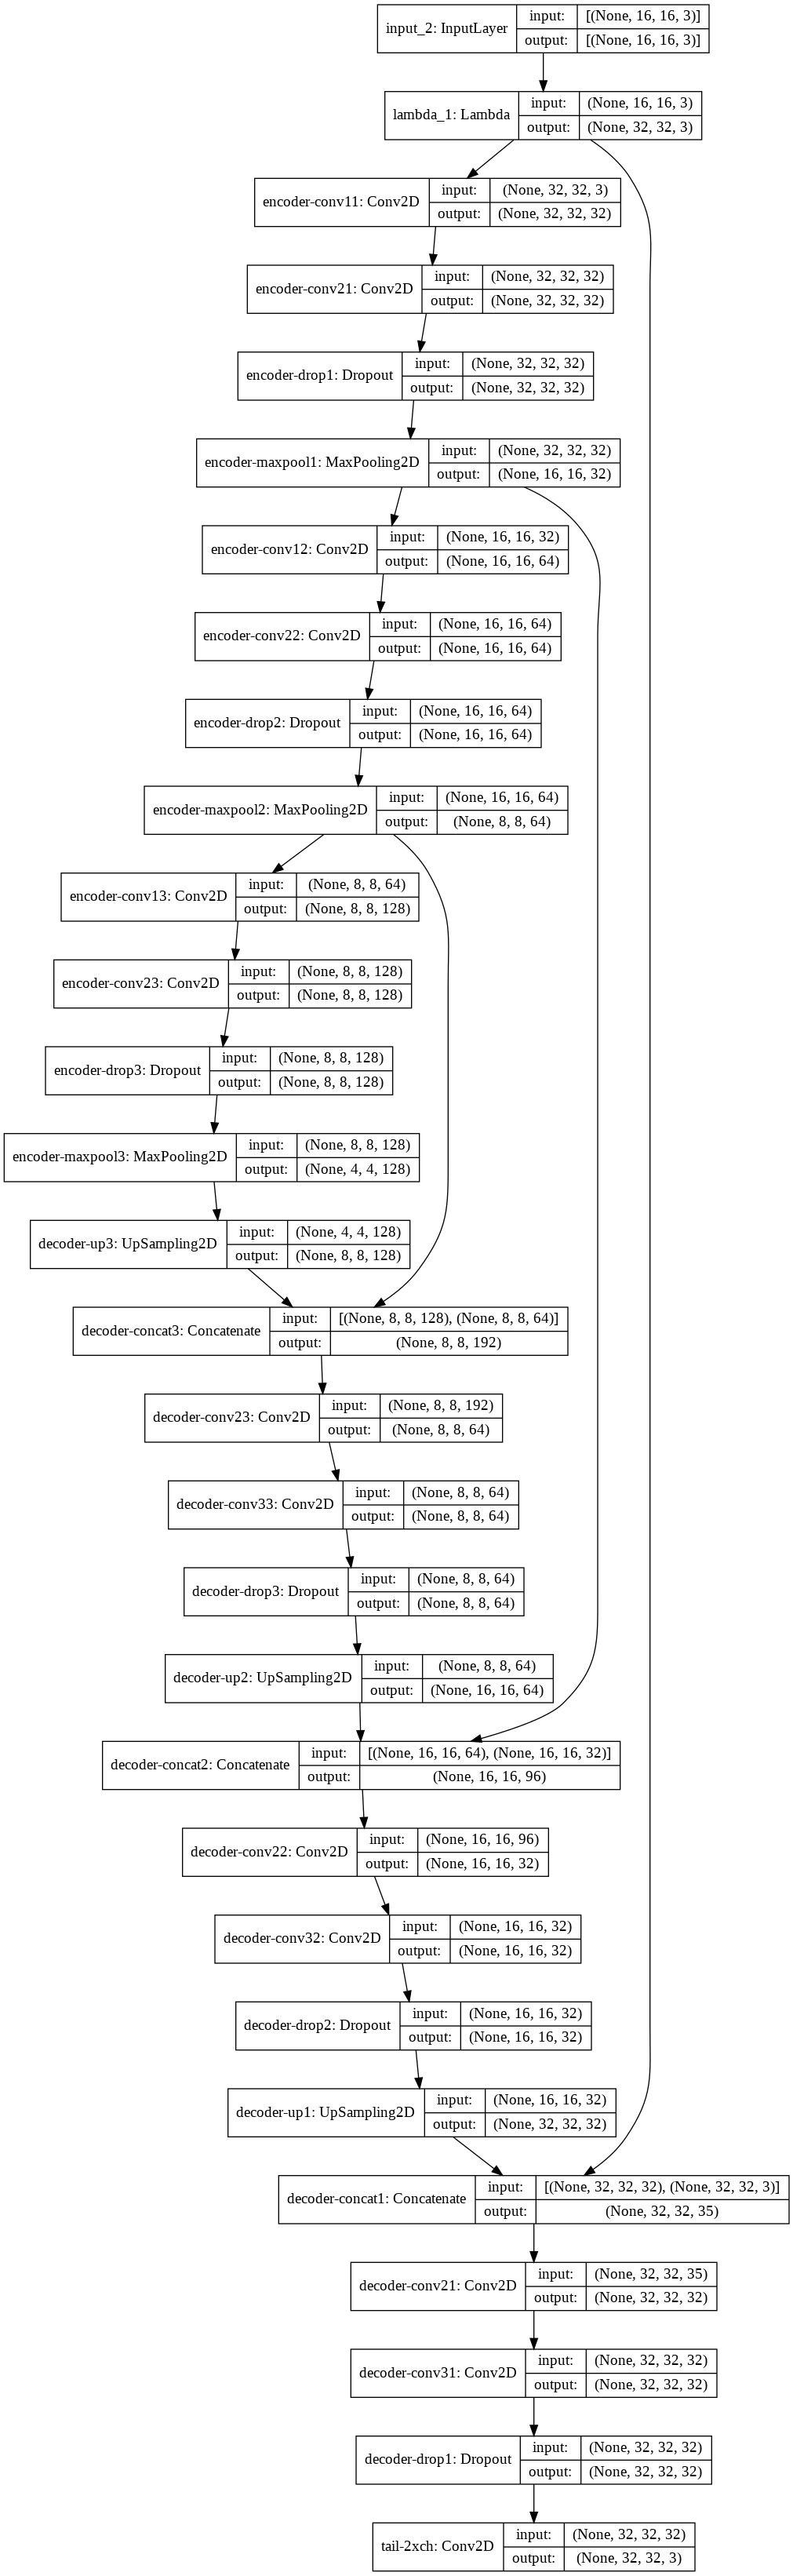

In [67]:
plot_model(unet, to_file = 'unet.png', show_shapes = True)

# Entrenamiento

In [68]:
from keras import optimizers

In [69]:
epochs     = 50        # número de epocas
batch_size = 128       # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

In [70]:
unet.compile(optimizer = optimizers.Adam(lr = alpha, decay = decay),
             loss      = 'mae',
             metrics   = ['accuracy'])

In [71]:
tic = time.time()

history = unet.fit(x                = X_train,
                   y                = Y_train,
                   batch_size       = batch_size,
                   epochs           = epochs,
                   validation_split = 0.2,
                   verbose          = 1)

print('\n Tiempo de entrenamiento:', time.time() - tic, 'segundos')

Epoch 1/50
63/63 [==============================] - 33s 29ms/step - loss: 0.3421 - accuracy: 0.1800 - val_loss: 0.1488 - val_accuracy: 0.4412
Epoch 2/50
63/63 [==============================] - 1s 20ms/step - loss: 0.1190 - accuracy: 0.4838 - val_loss: 0.0576 - val_accuracy: 0.7325
Epoch 3/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0787 - accuracy: 0.6590 - val_loss: 0.0393 - val_accuracy: 0.8488
Epoch 4/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0651 - accuracy: 0.7191 - val_loss: 0.0313 - val_accuracy: 0.8887
Epoch 5/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0572 - accuracy: 0.7650 - val_loss: 0.0256 - val_accuracy: 0.9041
Epoch 6/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0528 - accuracy: 0.7957 - val_loss: 0.0225 - val_accuracy: 0.9143
Epoch 7/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0488 - accuracy: 0.8119 - val_loss: 0.0203 - val_accuracy: 0.9185
Epoch 8/50
6

# Gráficas

In [72]:
def plot_loss_metric(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
    plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
    plt.xlabel('Epocas')
    plt.ylabel('loss')
    plt.legend()

    plt.show()


def plot_accuracy_metric(history):
    acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, acc_values, 'b', label='Accuracy')
    plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

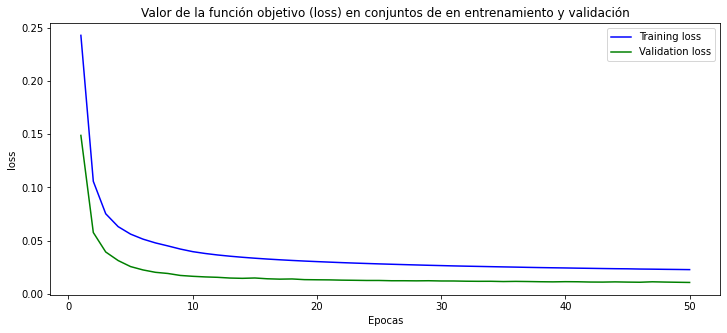

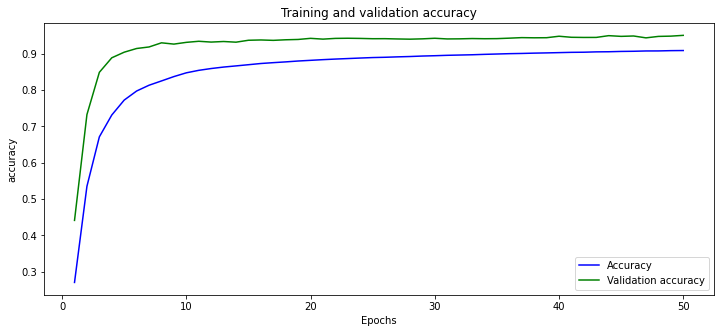

In [73]:
plot_loss_metric(history)
plot_accuracy_metric(history)

# Predicción

In [74]:
tic = time.time()
Y_train_pred = unet.predict(X_train)
print('\n Tiempor de predicción de todos los datos de prueba:', time.time()-tic, 'segundos')


 Tiempor de predicción de todos los datos de prueba: 1.0331923961639404 segundos


# Reconstrucción

Ahora realizaremos super-resolución con la red entrenada. Para ello crearemos un segundo modelo que tenga como dimensión de entrada $ (512, 512, 3) $ y como dimensión de salida $ (1024, 1024, 3) $.

In [75]:
img_dim                             = (512, 512, 3,)
filters_per_block                   = np.array([num_channels, 32, 64, 128])
num_blocks                          = len(filters_per_block)   
kernel_size                         = (3,3)
drop                                = 0.25*np.ones(num_blocks)
drop

array([0.25, 0.25, 0.25, 0.25])

In [76]:
# Encoder
nm= 'encoder'
Xdicc={}

Xin  = Input(shape=(img_dim), name = "x_true")

X = Lambda(lambda image: tf_resize_image(image, (1024, 1024)))(Xin)
# resize image layer
Xdicc[0] = X
numFilters=filters_per_block[0]
print(0, numFilters, X.shape)

for i in range(1,num_blocks):
    numFilters=filters_per_block[i]
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv1'+str(i))(X) 
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv2'+str(i))(X)
    X = Dropout(rate=drop[i], name='encoder-drop'+str(i))(X)
    X = MaxPooling2D(pool_size=(2,2), padding='valid', name='encoder-maxpool'+str(i))(X)
    Xdicc[i] = X
    print(i, numFilters, Xdicc[i].shape) 
      
# Decoder

Y=X
for i in range(num_blocks-1,0,-1):
    if i>1:
        numFilters = filters_per_block[i-1] 
    else:
        numFilters = 32
    #print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = UpSampling2D(size=2, name='decoder-up'+str(i))(Y)  
    print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2'+str(i))(Y)
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3'+str(i))(Y)
    Y = Dropout(rate=drop[i], name='decoder-drop'+str(i))(Y)
    
# Tail 

Y = Conv2D(3, kernel_size=(3,3), 
           padding='same', 
           activation=None,
           name='tail-2xch')(Y)
print(Y.shape)

0 3 (None, 1024, 1024, 3)
1 32 (None, 512, 512, 32)
2 64 (None, 256, 256, 64)
3 128 (None, 128, 128, 128)
3 64 (None, 256, 256, 128) (None, 256, 256, 64)
2 32 (None, 512, 512, 64) (None, 512, 512, 32)
1 32 (None, 1024, 1024, 32) (None, 1024, 1024, 3)
(None, 1024, 1024, 3)


In [77]:
unet_sr = Model(inputs=Xin,
                 outputs=[Y],
                 name='UnetModified')

unet_sr.compile(optimizer = optimizers.Adam(lr = alpha, decay = decay),
             loss      = 'mae',
             metrics   = ['accuracy'])

In [78]:
resumen(unet_sr)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    x_true           [(None, 512, 512, 3)]    [(None, 512, 512, 3)]             0
1    lambda_2         (None, 512, 512, 3)      (None, 1024, 1024, 3)             0
2    encoder-conv11   (None, 1024, 1024, 3)    (None, 1024, 1024, 32)          896
3    encoder-conv21   (None, 1024, 1024, 32)   (None, 1024, 1024, 32)         9248
4    encoder-drop1    (None, 1024, 1024, 32)   (None, 1024, 1024, 32)            0
5    encoder-maxpool1 (None, 1024, 1024, 32)   (None, 512, 512, 32)              0
6    encoder-conv12   (None, 512, 512, 32)     (None, 512, 512, 64)          18496
7    encoder-conv22   (None, 512, 512, 64)     (None, 512, 512, 64)          36928
8    encoder-drop2    (None, 512, 512, 64)     (None, 512, 512, 64)              0
9    encoder-maxpool2 (None, 512, 512, 64)     (None, 256, 256, 64)              0
10   encoder-conv13   (None, 256, 256, 64)     (None, 256, 256, 128)         73856
11  

In [80]:
# Cargamos pesos de la red entrenada
unet_sr.set_weights(unet.get_weights())
# Predecimos super-resolución de conjunto de prueba
img_recov = unet_sr.predict(X_test)

In [ ]:
print(Y_test.shape, X_test.shape, img_recov.shape)

(10, 1024, 1024, 3) (10, 512, 512, 3) (10, 1024, 1024, 3)


# Resultados

In [174]:
import tabulate
from sklearn.metrics import mean_absolute_error

## Errores de Reconstrucción

In [177]:
def show_errors(input_imgs, target_imgs, preditec_imgs) :
  errors = []
  # Obtengo imágenes con interpolación bicúbica
  interpolation = [cv2.resize(img,target_imgs[0].shape[:2] ,interpolation=cv2.INTER_CUBIC) for img in input_imgs]
  interpolation = np.array(interpolation, dtype = np.float32)

  for i in range(input_imgs.shape[0]) :
    # Obtengo error por canal
    error_unet  = mean_absolute_error(target_imgs[i][0], preditec_imgs[i][0])
    error_unet += mean_absolute_error(target_imgs[i][1], preditec_imgs[i][1])
    error_unet += mean_absolute_error(target_imgs[i][2], preditec_imgs[i][2])

    # Obtengo error por canal
    error_interpolation  = mean_absolute_error(target_imgs[i][0], interpolation[i][0])
    error_interpolation += mean_absolute_error(target_imgs[i][1], interpolation[i][1])
    error_interpolation += mean_absolute_error(target_imgs[i][2], interpolation[i][2])

    errors.append([i, error_unet / 3.0, error_interpolation/3.0])
  
  errors = np.array(errors)

  print(tabulate.tabulate(errors, headers = ['Img', 'MAE Unet', 'MAE Interpolación']))

In [178]:
show_errors(X_test, Y_test, img_recov)

  Img    MAE Unet    MAE Interpolación
-----  ----------  -------------------
    0  0.0152132            0.008732
    1  0.0156167            0.00336991
    2  0.0142714            0.00644014
    3  0.00841867           0.00218163
    4  0.0108584            0.00487977
    5  0.0130533            0.00488415
    6  0.0222097            0.00830371
    7  0.0151419            0.0071648
    8  0.0251809            0.00400743
    9  0.017231             0.0081617


In [163]:
def plot_images(images):
    w=10
    h=10
    fig=plt.figure(figsize=(15, 4))
    columns = 3
    rows = 1
    index = 0
    titles = ['Input', 'Scaled', 'predicted']
    for i in range(1, columns*rows +1):
        img = images[index]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title('%s (%dx%d): ' % (titles[i-1], img.shape[0], img.shape[1]))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        index += 1
    plt.show()

In [179]:
def show_images (input_imgs, target_imgs, preditec_imgs) :
  # Show Images
  errors         = []
  for i in range(input_imgs.shape[0]) :
    plot_images([target_imgs[i], input_imgs[i], preditec_imgs[i]])
    plot_images([target_imgs[i][300:400,300:400], input_imgs[i][150:200,150:200], preditec_imgs[i][300:400,300:400]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


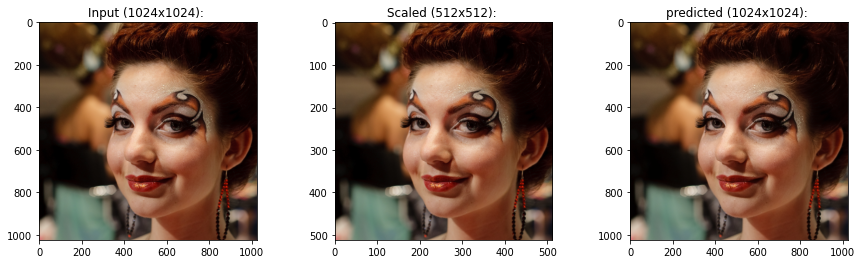

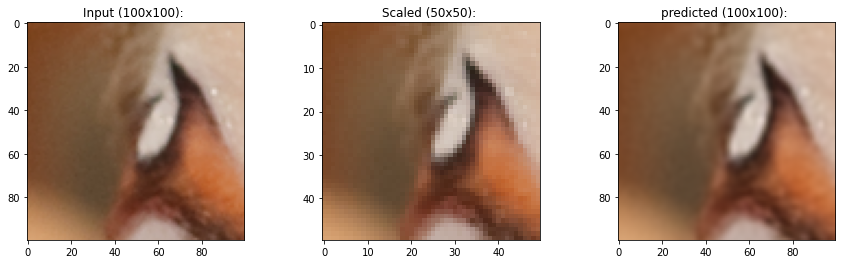

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


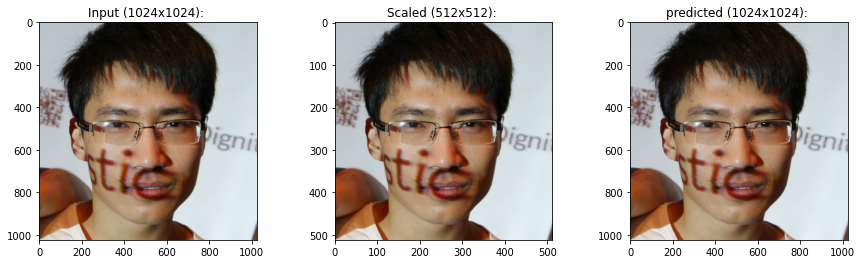

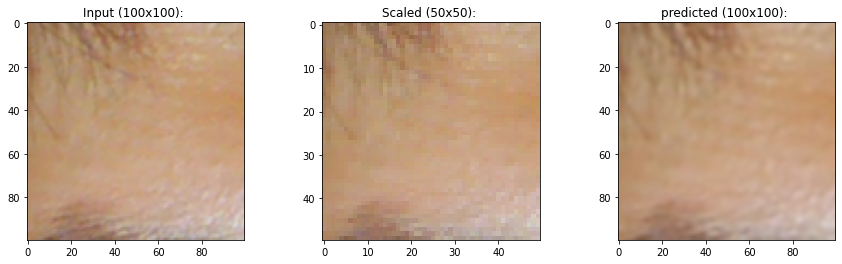

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


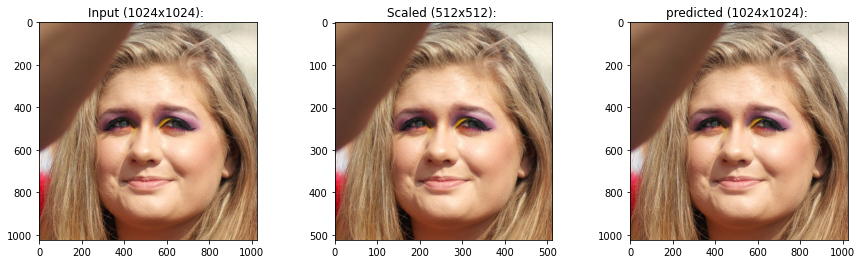

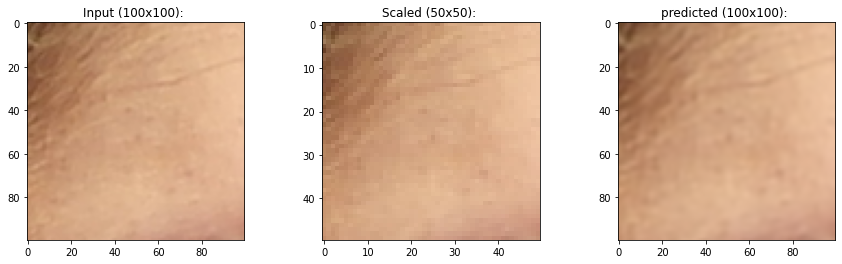

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


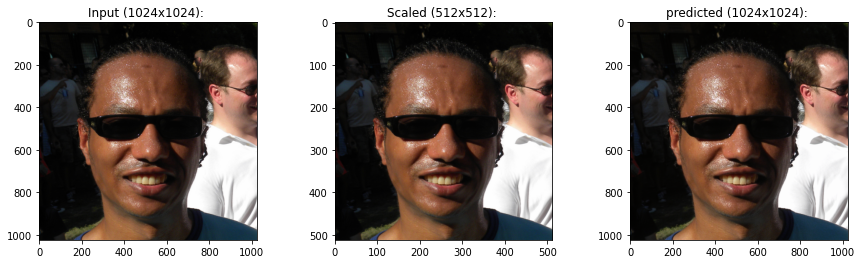

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


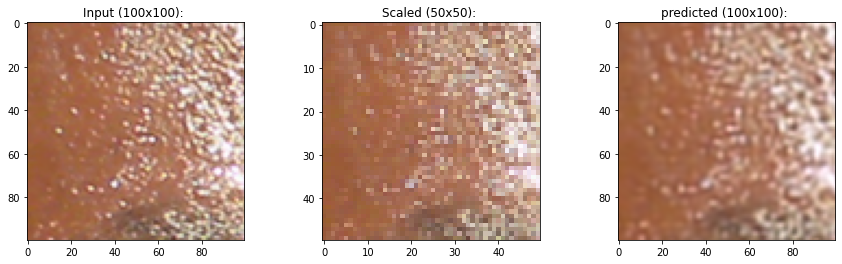

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


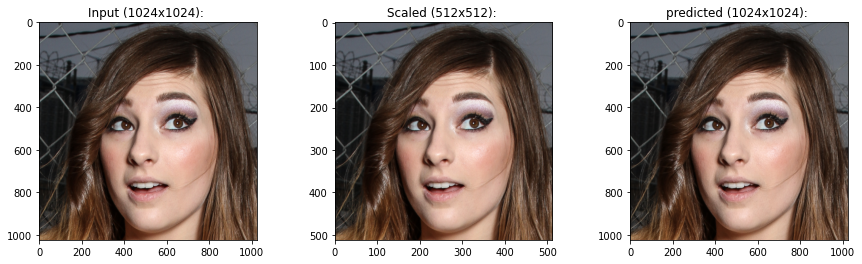

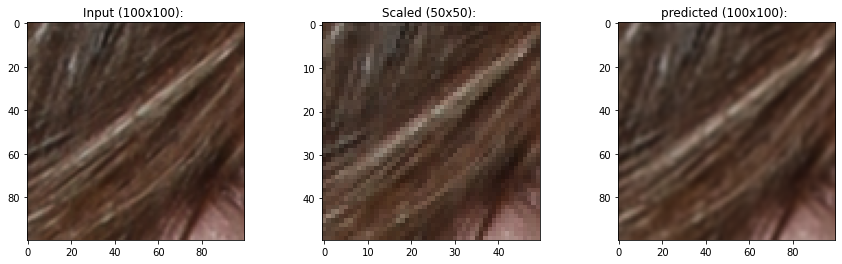

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


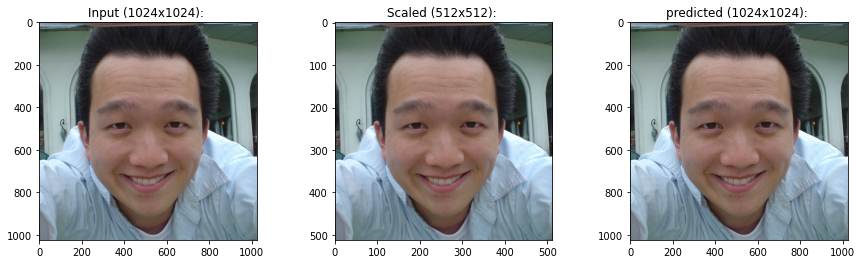

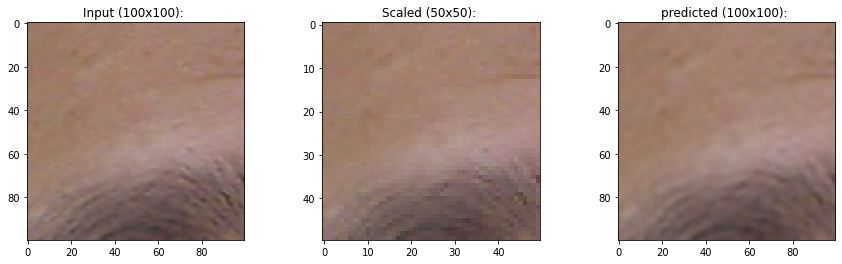

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


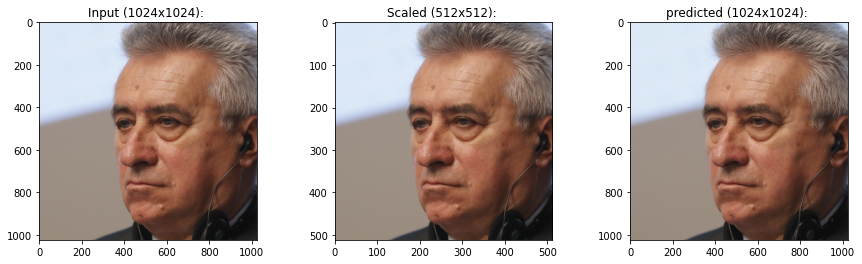

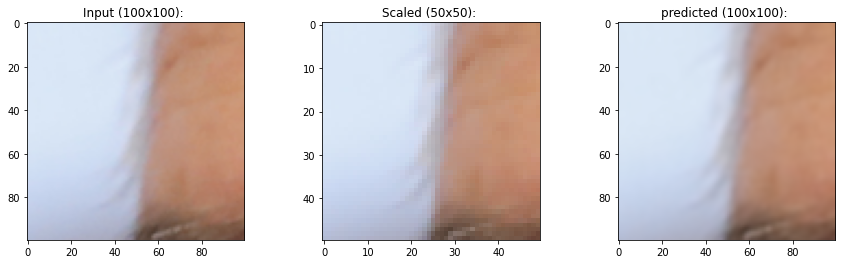

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


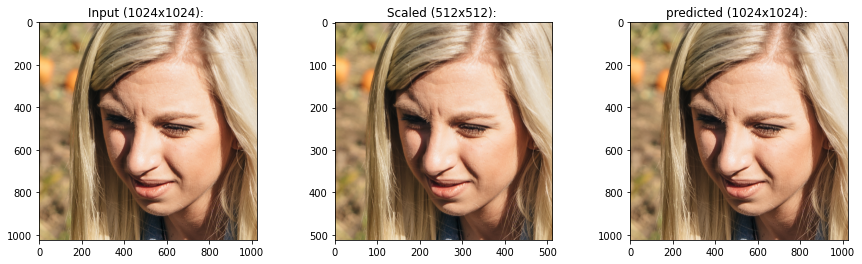

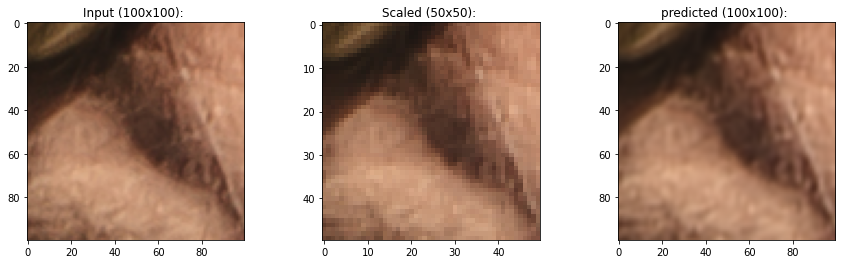

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


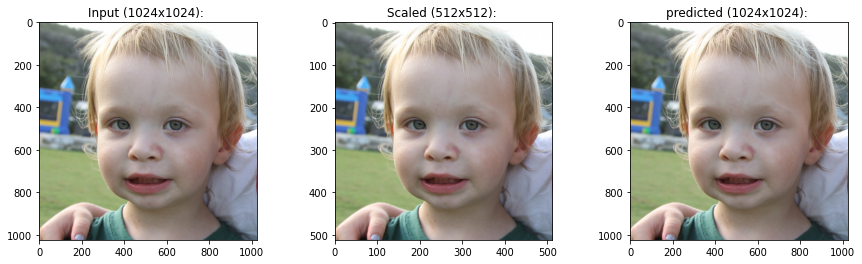

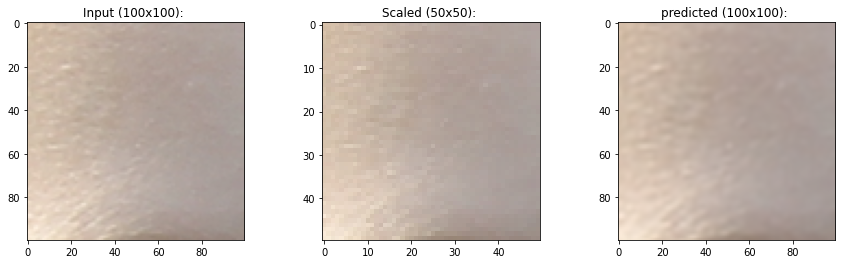

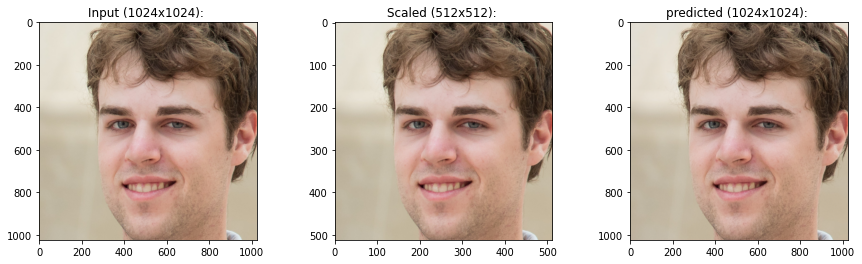

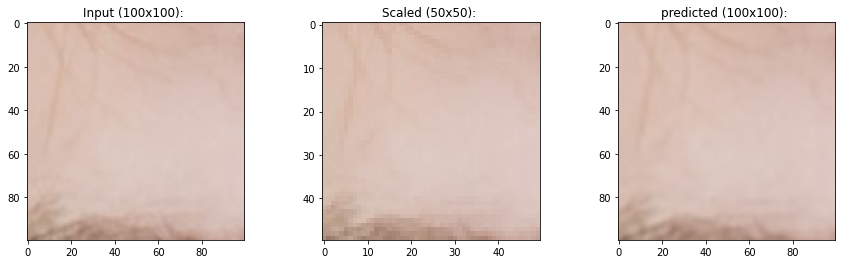

In [167]:
show_images(X_test, Y_test, img_recov)

# Conclusiones

Se observa que el error $ MAE $ para la super-resolución de la UNet está por abajo del $3\%$ respecto a la imagen original mientras que para la reconstrucción con interpolación bicúbica está por abajo del $1\%$. Para muestro ploteo de imágenes, la primera imagen corresponde a la original de $ 1024 \times 1024 \times 3 $, la imagen del centro es la imagen escalada a $ 512 \times 512 \times 3 $ y la última corresponde al resultado de la red en super-resolución $ 1024 \times 1024 \times 3 $.

Al hacer zoom sobre una región de $100$ pixeles se observa que la imagen reescalada mantiene un pixeleado notable respecto a la imagen original. El resultado dado por la UNet ha eliminado este pixeleado de manera significativa, aunque observando la tabla de errores, sigue teniendo una significancia del $3\%$ en promedio. 

Para reducir el error se podría aumentar el conjunto de entrenamiento, es decir, el número de parches, aunque lo anterior representa un aumento en el costo computacional. Además, podríamos aumentar el ruido utilizando un dataset que no tengo el fondo borroso, ya que ahí el pixeleado se nota menos (dado que todos los valores de esa región son muy similares)